# ▒ 중고차 가격 예측 및 시장 인사이트 분석 ▒


*   문제정의: 중고차 가격이 어떤 요인에 의해 결정되는지 분석하고 가격을 예측할 수 있는 모델 개발
*   데이터셋: 약 100만건의 차량 거래 데이터 (차량 스펙, 연식, 주행거리, 사고 이력 등)
*   목표:
      *   중고차 시장의 주요 패턴과 인사이트 도출
      *   차량 가격을 예측하는 모델 구축 및 성능 평가





## 0. 환경설정

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

## 1. 데이터 불러오기

In [2]:
df = pd.read_csv("/content/drive/MyDrive/data/vehicle_price_prediction.csv")
print("데이터셋 크기:", df.shape)
df.head()

데이터셋 크기: (1000000, 20)


,make,model,year,mileage,engine_hp,transmission,fuel_type,drivetrain,body_type,exterior_color,interior_color,owner_count,accident_history,seller_type,condition,trim,vehicle_age,mileage_per_year,brand_popularity,price
0,Volkswagen,Jetta,2016,183903,173,Manual,Electric,RWD,Sedan,Blue,Brown,5,NaN,Dealer,Excellent,EX,9,20433.666667,0.040054,7208.52
1,Lexus,RX,2010,236643,352,Manual,Gasoline,FWD,Sedan,Silver,Beige,5,Minor,Dealer,Good,LX,15,15776.200000,0.039921,6911.81
2,Subaru,Crosstrek,2016,103199,188,Automatic,Diesel,AWD,Sedan,Silver,Beige,5,NaN,Dealer,Excellent,Touring,9,11466.555556,0.040230,11915.63
3,Cadillac,Lyriq,2016,118889,338,Manual,Gasoline,AWD,SUV,Black,Gray,3,NaN,Private,Good,Base,9,13209.888889,0.039847,25984.79
4,Toyota,Highlander,2018,204170,196,Manual,Diesel,FWD,Sedan,Red,Brown,5,Minor,Dealer,Excellent,Sport,7,29167.142857,0.039627,8151.30


* 차량의 기본적인 사양부터 외관 및 내관 정보, 추가적인 수치 피처까지 다양한 종류의 변수를 포함하고 있음
* 10만건의 관측치와 20개의 피처로 충분히 복잡한 머신러닝 모델을 훈련시키기에 적합해 보임
* year(vehicle_age)과 mileage, price는 음의 상관관계를 가지고 있을 가능성이 크기 떄문에 그래프로 확인

## 2. 데이터 탐색 및 전처리(EDA)

In [ ]:
# 결측치
df.info()
df.isna().sum().sort_values(ascending=False).head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   make              1000000 non-null  object 
 1   model             1000000 non-null  object 
 2   year              1000000 non-null  int64  
 3   mileage           1000000 non-null  int64  
 4   engine_hp         1000000 non-null  int64  
 5   transmission      1000000 non-null  object 
 6   fuel_type         1000000 non-null  object 
 7   drivetrain        1000000 non-null  object 
 8   body_type         1000000 non-null  object 
 9   exterior_color    1000000 non-null  object 
 10  interior_color    1000000 non-null  object 
 11  owner_count       1000000 non-null  int64  
 12  accident_history  249867 non-null   object 
 13  seller_type       1000000 non-null  object 
 14  condition         1000000 non-null  object 
 15  trim              1000000 non-null  object 
 16  v

,0
accident_history,750133
make,0
year,0
model,0
mileage,0
engine_hp,0
fuel_type,0
transmission,0
body_type,0
exterior_color,0


* accident_history에 많은 결측값이 관찰됨
* 데이터 내의 none(사고 없음)이 결측값으로 측정된 것으로 보임 -> 결측값 보정 필요

In [3]:
df['accident_history'] = df['accident_history'].fillna('none')

In [ ]:
print("\n컬럼별 데이터 타입:")
print(df.dtypes)


컬럼별 데이터 타입:
make                 object
model                object
year                  int64
mileage               int64
engine_hp             int64
transmission         object
fuel_type            object
drivetrain           object
body_type            object
exterior_color       object
interior_color       object
owner_count           int64
accident_history     object
seller_type          object
condition            object
trim                 object
vehicle_age           int64
mileage_per_year    float64
brand_popularity    float64
price               float64
dtype: object


* 수치형 변수와 범주형 변수가 혼재되어 있음
* 범주형 변수가 많으므로 One-Hot Encoding이나 Label Encoding 등의 전처리 필수

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,1000000.0,2017.453816,3.902285,2000.000000,2015.000000,2018.000000,2020.000000,2025.000000
mileage,1000000.0,112660.126464,72088.236925,500.000000,57654.000000,103331.000000,157865.000000,300000.000000
engine_hp,1000000.0,235.664301,93.614773,90.000000,162.000000,215.000000,300.000000,581.000000
owner_count,1000000.0,3.477846,1.544856,1.000000,2.000000,4.000000,5.000000,5.000000
vehicle_age,1000000.0,7.585987,3.829534,1.000000,5.000000,7.000000,10.000000,25.000000
mileage_per_year,1000000.0,14540.674200,6108.901522,33.333333,10487.633523,14688.118056,18685.942308,55391.000000
brand_popularity,1000000.0,0.040001,0.000234,0.039318,0.039842,0.040022,0.040148,0.040484
price,1000000.0,20329.302593,13644.467189,1500.000000,10324.527500,17864.740000,27601.402500,93422.090000


In [ ]:
df.describe(include='object').T

,count,unique,top,freq
make,1000000,25,Kia,40484
model,1000000,105,300,20202
transmission,1000000,2,Automatic,500263
fuel_type,1000000,3,Electric,359597
drivetrain,1000000,3,AWD,361110
body_type,1000000,7,SUV,406693
exterior_color,1000000,6,White,166934
interior_color,1000000,4,Beige,250570
accident_history,1000000,3,none,750133
seller_type,1000000,2,Dealer,699710


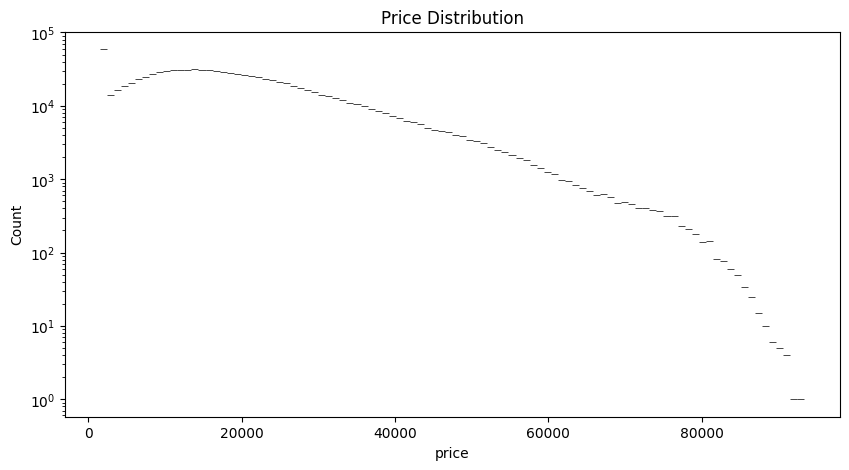

In [ ]:
# 1. 가격 분포

plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=100, log_scale=(False, True))
plt.title("Price Distribution")
plt.show()

* 가격 데이터가 오른쪽으로 치우쳐져 있음(데이터가 비교적 낮은 가격대의 중고차에 몰려 있고 매우 비싼 소수의 차령으로 형성되어 있음)
* 심한 불균형으로 데이터가 많은 저가 구간에 편향되어 모델을 학습할 가능성이 높음


> price 변수의 심한 오른쪽 치우침을 해결하기 위해 모델 훈련 전에 로그 변환을 적용하는 것이 필수적



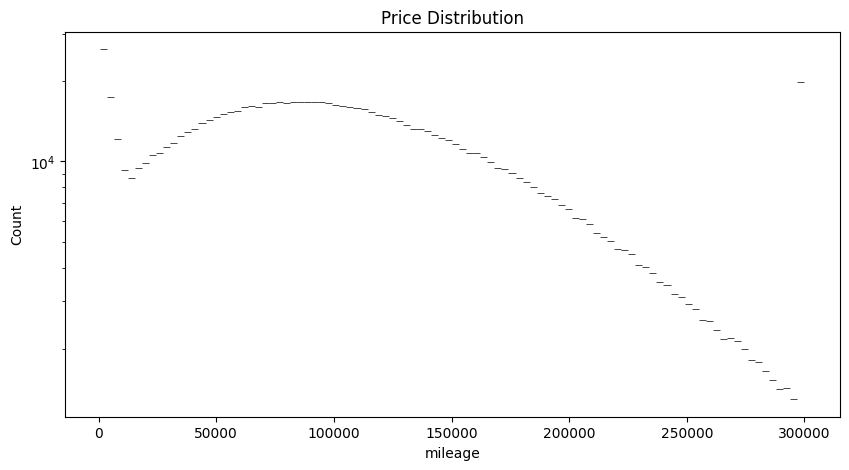

In [ ]:
# 2. mileage 분포

plt.figure(figsize=(10,5))
sns.histplot(df['mileage'], bins=100, log_scale=(False, True))
plt.title("Price Distribution")
plt.show()

* 데이터가 오른쪽으로 치우쳐져 있음(100,000 마일을 넘어갈수록 곽측치가 급격히 줄어 긴꼬리 형성)


> mileage 변수의 심한 오른쪽 치우침을 해결하기 위해 모델 훈련 전에 로그 변환을 적용하는 것이 필수적



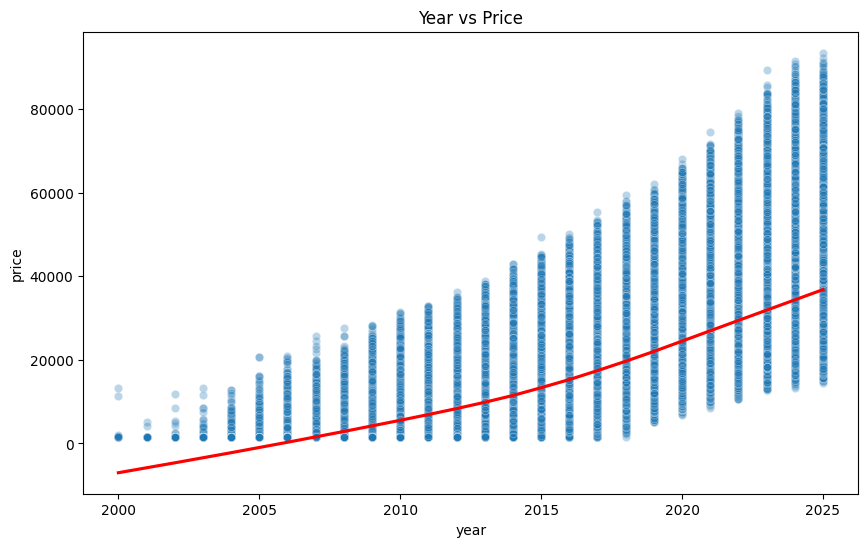

In [ ]:
# 3. 연식(year) vs 가격(price)

plt.figure(figsize=(10,6))
sns.scatterplot(x="year", y="price", data=df, alpha=0.3)
sns.regplot(x="year", y="price", data=df, scatter=False, color="red", lowess=True)
plt.title("Year vs Price")
plt.show()

* 최근 연식일수록 가격이 높고 시간이 지날수록 가격이 떨어지는 일반적인 패턴이 뚜렷
* 빨간색 회귀선을 보면 선형적이지 않고 점차 가파르게 상승하는 곡선 형태 -> 최근 연식일수록 연식 1년 변화가 가격에 미치는 영향이 커진다는 것을 의미
* 다만 같은 연식이라도 가격 차이가 큼 (아마 브랜드, 주행거리, 연료 종류 등 다른 변수의 영향)
* 차량 연식은 강력한 가격 예측 변수지만 단독으로는 부족하며 다른 특성과의 조합 필요

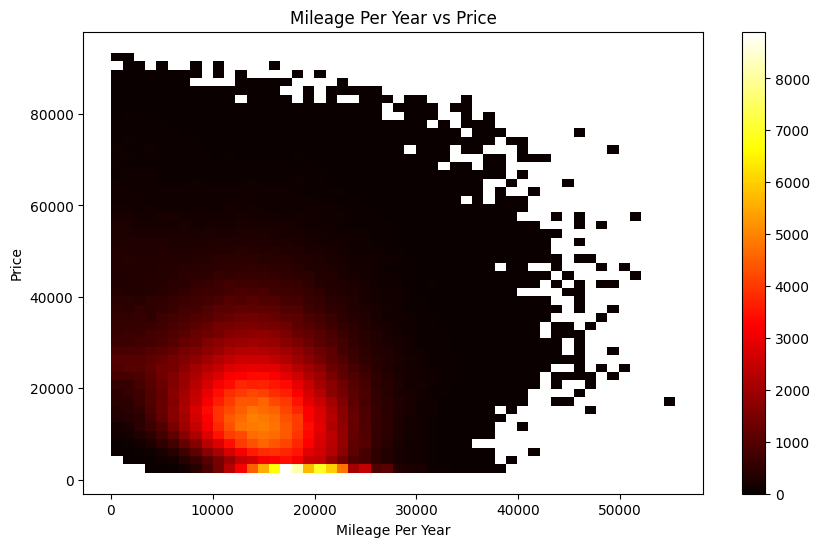

In [ ]:
# 4. 연간 주행 거리(mileage_per_year) vs 가격(price)

plt.figure(figsize=(10, 6))
sns.histplot(x='mileage_per_year', y='price', data=df, bins=50, cmap='hot', cbar=True)
plt.title('Mileage Per Year vs Price')
plt.xlabel('Mileage Per Year')
plt.ylabel('Price')
plt.show()

*  mileage가 10,000 ~ 20,000 사이 price가 10,000 ~ 20,000 사이일때 데이터가 가장 많이 집중되어 있음 -> 중고차 거래는 연간 주행거리가 평균적이면서도 비교적 저렴하 가격대의 차량에서 발생
* 연간 주행거리는 가격에 대한 강력한 감가상각 요인이며 주행 거리가 많을수록 차량이 높은 가격을 받을 가능성이 크게 낮아짐
* 고가 차량이 높은 가치를 유지하기 위해서는 낮은 연간 주행 거리는 필수적
* 연간 주행 거리가 30,000 이상인 경우 데이터의 밀도가 급격히 낮아지므로 모델이 이 희소한 영역에 대한 예측력이 낮아질 수 있음

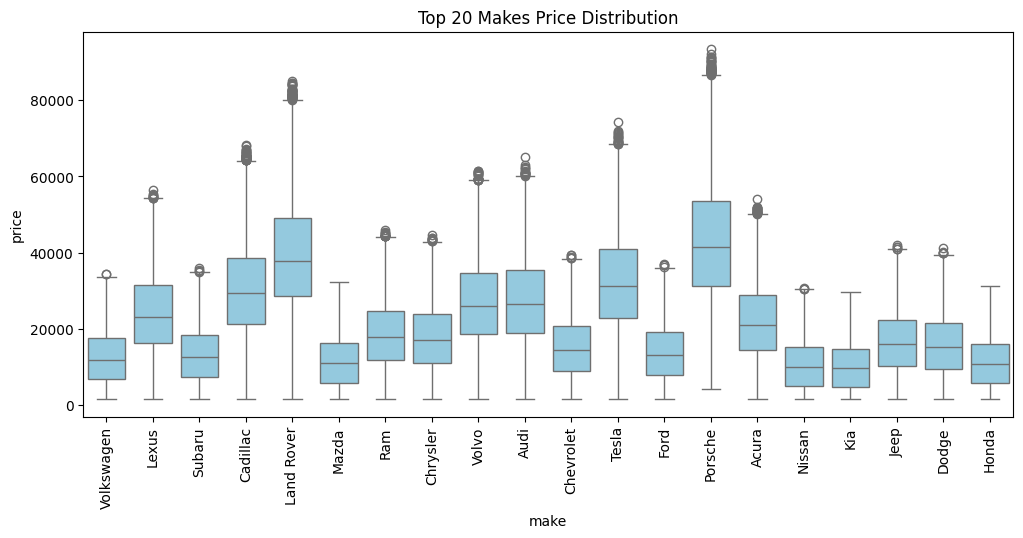

In [ ]:
# 5.제조사(make) 별 평균 가격(price)

top_makes = df["make"].value_counts().nlargest(20).index
plt.figure(figsize=(12,5))
sns.boxplot(data=df[df["make"].isin(top_makes)], x="make", y="price", color="skyblue")
plt.xticks(rotation=90)
plt.title("Top 20 Makes Price Distribution")
plt.show()

* make 별로 각 박스 위치가 다양
* 같은 make 안에서도 다양한 범위의 가격이 형성되어 있음 -> 각 make의 특정 모델이 높은 가격을 형성하고 있을 수 있음

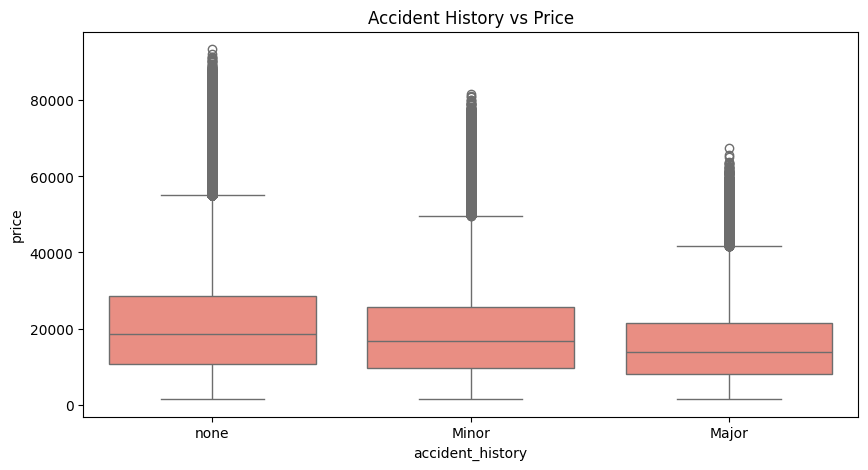

In [ ]:
# 6. 사고 이력(accident_history) vs 가격(price)

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="accident_history", y="price", color="salmon")
plt.title("Accident History vs Price")
plt.show()

* 사고 이력이 없을때 가장 가격이 높고 사고가 major일때 가격이 가장 낮게 형성되는 일반적인 경향을 띄고 있음
* 사고가 커질수록 차량의 가치는 점진적으로 하락
* 각 박스 그룹의 이상치를 살펴보면 사고 이력이 있어도 다른 조건이 최상급이면 여전히 높은 가격을 받을 수 있음을 알 수 있음

## 3. 데이터 전처리

In [4]:
# 차량 연식 → 차량 나이
current_year = 2025
df['vehicle_age'] = current_year - df['year']

# 가격 로그 변환
df['price_log'] = np.log1p(df['price'])

# mileage 로그 변환
df['mileage_log'] = np.log1p(df['mileage'])

In [5]:
# 범주형 변수 인코딩

# 1. make에 대한 Target Encoding
make_price_mean = df.groupby('make')['price_log'].mean()
df['mean_encoded_make'] = df['make'].map(make_price_mean)

# 2. model에 대한 Target Encoding
model_price_mean = df.groupby('model')['price_log'].mean()
df['mean_encoded_model'] = df['model'].map(model_price_mean)

# 3. 사고 심각도 매핑 (none=0, minor=1, major=2)
accident_map = {'none': 0, 'Minor': 1, 'Major': 2}
df['accident_severity'] = df['accident_history'].map(accident_map)

# 4. 사고 유무 플래그 (사고 있으면 1, 없으면 0)
df['accident_flag'] = df['accident_history'].apply(lambda x: 0 if x=='none' else 1)

# 5. One-Hot Encoding
one_hot_cols = [
    'transmission', 'fuel_type', 'drivetrain', 'body_type',
    'exterior_color', 'interior_color', 'seller_type', 'condition', 'trim'
]
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

## 4. 모델링

### 4.1 선형 모델

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 준비

cols_to_drop = ['price', 'make', 'model', 'accident_history']

df_model = df.drop(columns=cols_to_drop, errors='ignore')

X_linear = df_model.drop(['price_log'], axis=1)
y_linear = df_model['price_log']

X_train, X_test, y_train, y_test = train_test_split(X_linear, y_linear, test_size=0.2, random_state=123)

# 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 학습
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# 평가
y_pred_lr = lr.predict(X_test_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R²:", r2_lr)

Linear Regression RMSE: 0.2234698576306077
Linear Regression R²: 0.9325400934069012


* 선형회귀를 진행한 결과 RMSE 값은 약 0.22, 결정계수는 약 0.93으로 나타남
* 높은 $R^2$ 값은 모델이 전체적인 가격 변동 패턴을 잘 설명하고 있음을 의미하지만 RMSE가 0.22 수준이라는 점은 여전히 실제 가격 예측에서 일정 수준의 오차가 존재함을 시사
* 이는 가격 결정 요인 간의 비선형적 관계나 상호작용 효과를 단순 선형 구조가 완벽히 반영하지 못했기 때문이라고 판단됨



> 따라서 이후 단계에서 비선형 모델(Random Forest, XGBoost)을 추가 적용하여 예측 성능을 향상시키는 방향으로 분석 확장



### 4.2 트리 기반 모델

In [7]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

X_tree = df_model.drop(['price_log'], axis=1)
y_tree = df_model['price_log']

X_train, X_test, y_train, y_test = train_test_split(X_tree, y_tree, test_size=0.2, random_state=123)

# RandomForest
rf = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=123, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("RandomForest RMSE:", rmse_rf)
print("RandomForest R²:", r2_rf)

# XGBoost
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=123,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R²:", r2_xgb)

RandomForest RMSE: 0.06420077103224306
RandomForest R²: 0.994432139847609
XGBoost RMSE: 0.061609229889077036
XGBoost R²: 0.9948725741182293


* Random Forest와 XGBoost에서는 RMSE 값이 약 0.06으로 Linear Regression에 비해 3.5배 향상된 성능
* $R^2$ 값 역시 0.99 이상으로 향상되며 모델이 실제 차량 가격 변동의 대부분을 설명


> 이를 통해 자동차 가격은 단순 선형관계로 설명되기는 어렵고 브랜드, 사고 이력, 차량 연식 등 비선형적 상호작용이 중요한 영향을 미친다는 통찰을 얻음



## 5. 모델별 성능 비교

In [8]:
# 모델 성능 비교 (Linear Regression vs Random Forest vs XGBoost)

results = {
    'Model': ['Linear Regression', 'RandomForest', 'XGBoost'],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb],
    'R²': [r2_lr, r2_rf, r2_xgb]
}

results_df = pd.DataFrame(results)
print(results_df)

               Model      RMSE        R²
0  Linear Regression  0.223470  0.932540
1       RandomForest  0.064201  0.994432
2            XGBoost  0.061609  0.994873


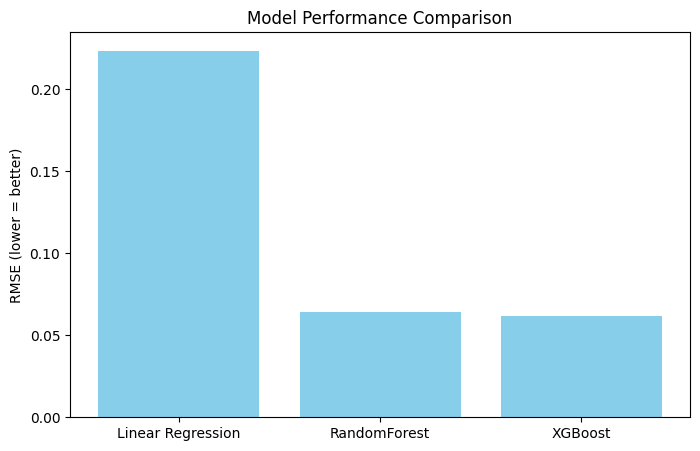

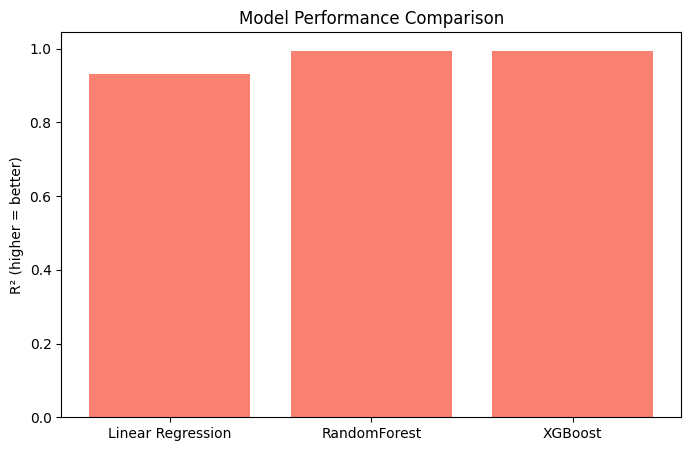

In [ ]:
# 성능 비교 시각화

plt.figure(figsize=(8,5))
plt.bar(results_df['Model'], results_df['RMSE'], color='skyblue')
plt.ylabel("RMSE (lower = better)")
plt.title("Model Performance Comparison")
plt.show()

plt.figure(figsize=(8,5))
plt.bar(results_df['Model'], results_df['R²'], color='salmon')
plt.ylabel("R² (higher = better)")
plt.title("Model Performance Comparison")
plt.show()

## 6. 모델 해석: 예측에 영향을 미치는 주요 요인 분석

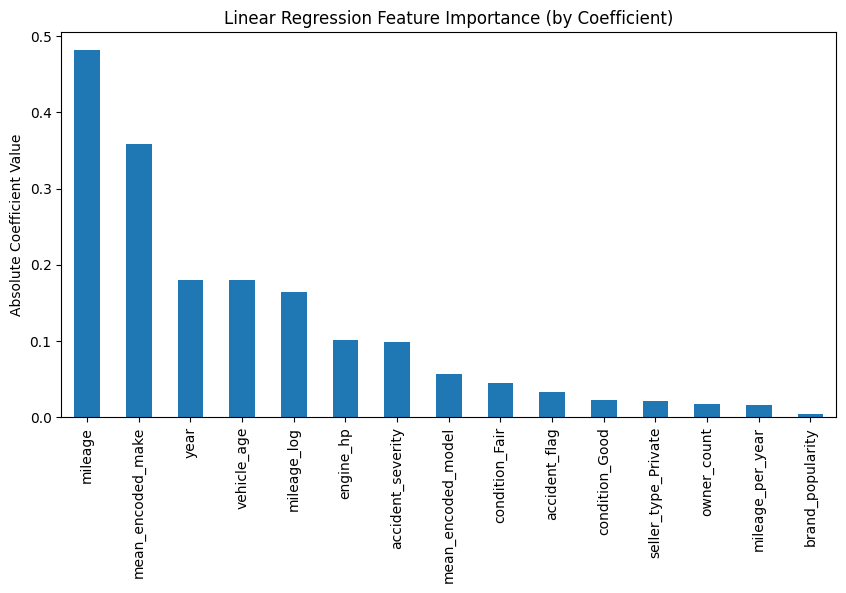

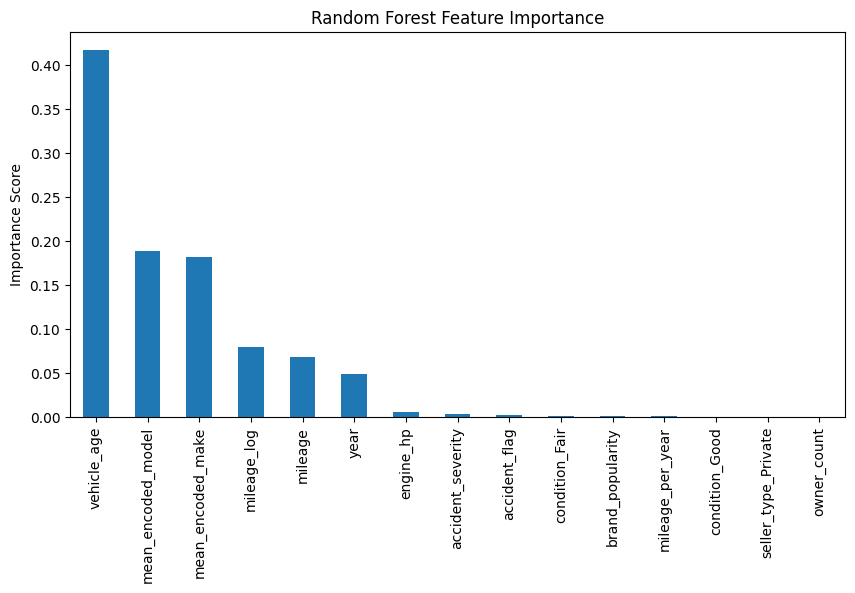

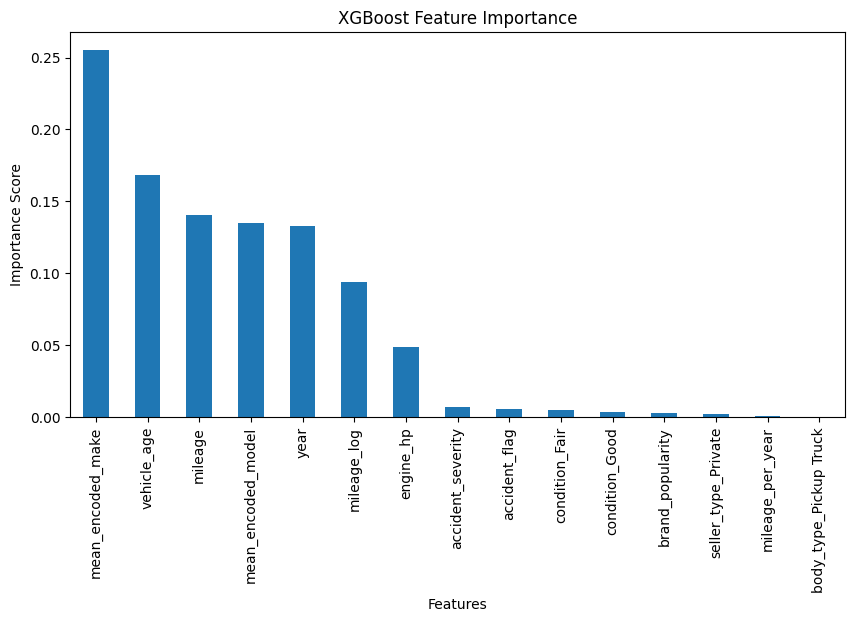

In [ ]:
# Linear Regression 중요 변수
coeff = pd.Series(np.abs(lr.coef_), index=X_train.columns)
coeff = coeff.sort_values(ascending=False)
plt.figure(figsize=(10,5))
coeff.head(15).plot(kind='bar')
plt.title('Linear Regression Feature Importance (by Coefficient)')
plt.ylabel('Absolute Coefficient Value')
plt.show()

# RandomForest 중요 변수

importances_rf = pd.Series(rf.feature_importances_, index=X_train.columns)
importances_rf = importances_rf.sort_values(ascending=False)
plt.figure(figsize=(10,5))
importances_rf.head(15).plot(kind='bar')
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance Score')
plt.show()

# XGBoost 중요 변수 추출
importances_xgb = pd.Series(xgb.feature_importances_, index=X_train.columns)
importances_xgb = importances_xgb.sort_values(ascending=False)
plt.figure(figsize=(10, 5))
importances_xgb.head(15).plot(kind='bar')
plt.title('XGBoost Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()



1.   Linear Regression
      * mileage가 가장 중요한 변수로 나타남 -> 주행거리가 늘어날수록 차령 가격이 하락하는 음의 선형관계가 강하게 작용
      * make 역시 중요한 요인 -> 특정 제조사의 평균 가격 수준이 차량 가치에 직접적 영향을 미침
      * year, vehicle_age 역시 상관성이 높음 -> 차량 사용 기간이 길수록 감가가 일어남을 반영


> 선형회귀 모델은 변수 간 비선형적 상호작용을 고려하지 못함 -> 선형모델은 전체적인 방향성과 주요 요인을 확인하는데는 유용하지만 RMSE 값이 약 0.22로 실제 예측 정확도는 제한적


2.   Random Foresrt
      * vehicle_age가 가장 높은 중요도를 보임 -> 감가상각의 핵심요인으로 작용
      * model, make가 상위권 -> 제조사와 모델에 따른 시장 가치 뚜렷
      * mileage 또한 중요 -> 주행거리가 늘어날수록 가격 하락 폭이 완만해지는 경향을 모델이 포착


> Random Forest는 비선형적 관계와 변수 간 상호작용을 포착해 선형회귀보다 성능이 향상됨


3.  XGBoost
      * make가 가장 중요한 변수로 나타남 -> 특정 브랜드의 중고차 시장 신뢰도나 수요가 가격에 강하게 반영됨
      * age, mileage 역시 지속적으로 높은 중요도 -> 감가 요인이지만 XGBoost는 이들의 비선형 조합을 더 잘 학습함
      * model, year 역시 가격에 영향 -> 제조사 내부에서도 특정 모델/연식별 가격 차이가 큼을 시사


> XGBoost는 Random Forest보다 데 세밀한 규칙 학습을 통해 RMSE가 더 낮음 -> 즉, 비선형적 특성과 변수 간 상호작용이 차량 가격 예측에서 매우 중요한 역할을 한다는 결론을 뒷바침


> XGBoost는 세 모델 중 가장 성능이 뛰어났지만 트리 기반 모델은 내부 의사결정 구조가 복잡하여 어떤 요인이 예측에 어떤 방향으로 작용했는지 해석하기 어렵다는 한계 존재 -> 따라서 최고 성능을 보인 XGBoost를 대상으로 SHAP 분석 수행





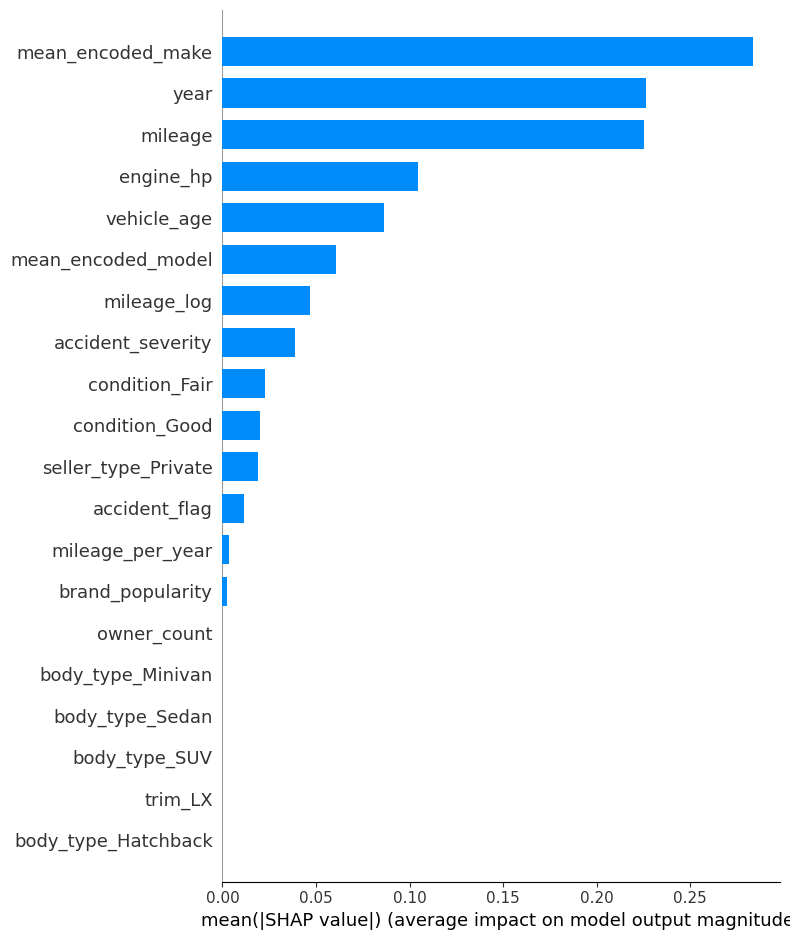

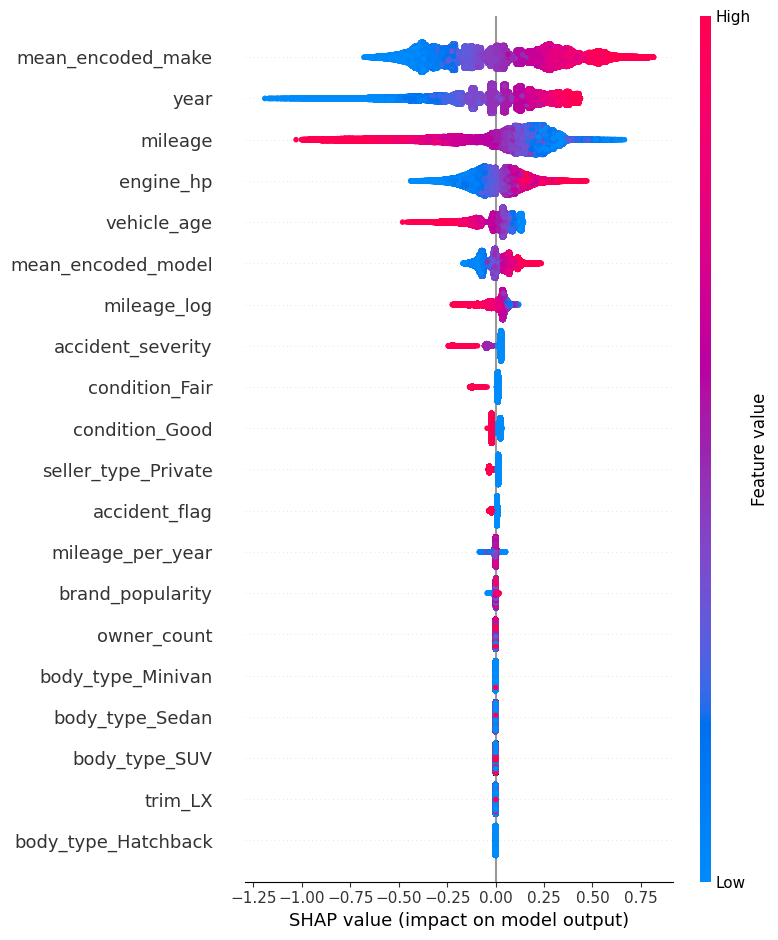

In [9]:
import shap

# XGBoost 해석
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# 요약 플롯 (전반적 변수 영향력)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 상세 플롯 (변수별 영향)
shap.summary_plot(shap_values, X_test)

* 제조사의 평균 가격이 가격 예측에 가장 큰 영향을 미침 -> 제조사의 시장 가치와 잔존 가치가 중고차 가격의 기본 수준을 결정한다는 기존 통찰 확보
* 연식은 두번째로 중요하며 차량이 최신일수록 가격을 높이는 경향이 큼
* 주행거리는 세번째로 중요하며 주행 거리가 길수록 가격을 낮추는 영향이 강함
* 이외에도 이 그래프를 통해 중고차 가격과 model, engine_hp 등은 양의 관계, vehicle_age, mileage 등은 음의 관계임을 알 수 있음

## 7. 예측 모델 적용 및 해석

예측된 차량 가격: 34441.0 원


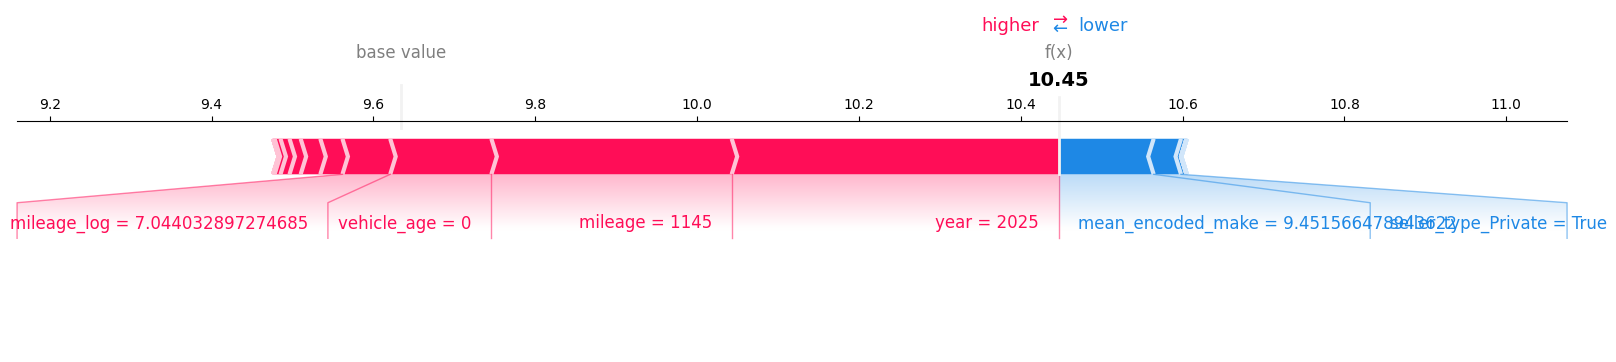

In [13]:
# 특정 차량 조건 입력
sample = X_test.iloc[0:1]

pred_price_log = xgb.predict(sample)[0]
pred_price = np.expm1(pred_price_log)

print("예측된 차량 가격:", round(pred_price, 2), "원")

# 해당 차량의 SHAP 해석
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, matplotlib=True)

예측된 차량 가격: 34441.0 원


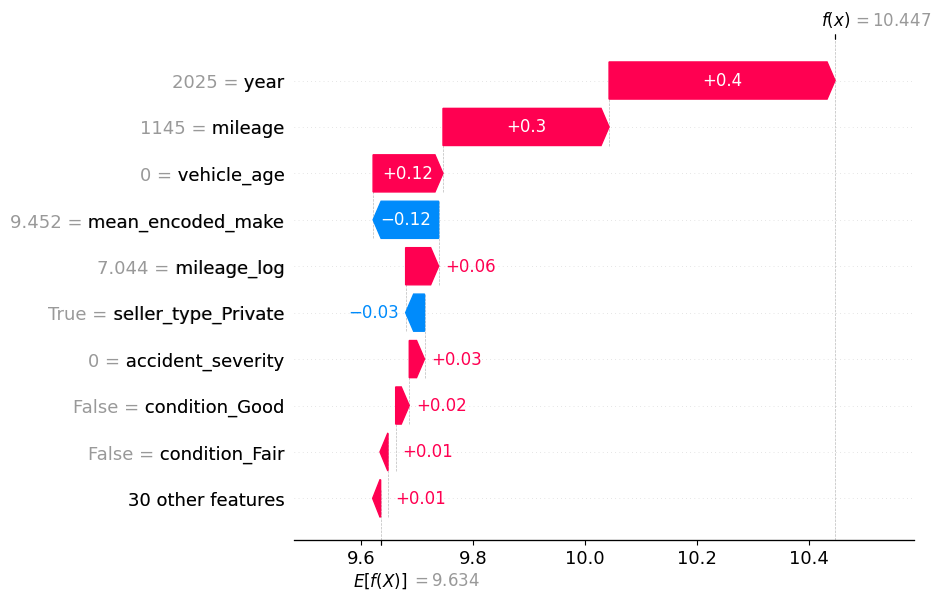

In [18]:
# 특정 차량 조건 입력
sample = X_test.iloc[0:1]

pred_price_log = xgb.predict(sample)[0]
pred_price = np.expm1(pred_price_log)

print("예측된 차량 가격:", round(pred_price, 2), "원")

# 해당 차량의 SHAP 해석
shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_values[0],
                                      base_values=explainer.expected_value,
                                      data=X_test.iloc[0],
                                      feature_names=X_test.columns))